# False Color Images
## EDS220: Assignment 4, Task 2

**Author:** Sofia Sarak

**Github repository:** https://github.com/sofiasarak/eds220-hwk4

### About 

**Purpose:** The following analyses use remote sensing data to explore the impacts of the Eaton and Palisades wildfires.

The two fires occurred nearly simultaneously in Los Angeles County in January 2025. Their impact was widespread, inflicting both ecological and infrastructural damage on the area. By using remote sensing data and assigning infrared bands to visible colors, we are able to highlight vegetation health, burn severity, and the extent of fire scars remnant after the fire. 

This notebook concludes with the creation of a false color image of the Eaton and Palisades Fires, highlighting the fire scar with an overlay of fire perimeters.

**Highlights:** 

1. *Using xarray and NetCDF data formats.* Our primary dataset comes from landsat, and must be read in using the `xarray` package.
2. *Plotting raster data.* The combination `.plot.imshow` ensures that our raster image plots. Arguments like `robust` ensure accurate plotting.
3. *False color imagery.* Certain features -- in this case, vegetation health -- are better highlighted by reflectance bands other than RGB (true color). In this analysis, we observe the effects of wildfire on vegetative by plotting different bands.

**About the data:** 

*Landsat/remote sensing*

The dataset used in this analysis is a simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmospherically corrected surface reflectance data, collected by the Landsat 8 satellite. Landsat data is provided by a series of Earth-observing satellites jointly managed by NASA and the U.S. Geological Survey (USGS), and stores a significant amount of reflectance information about the Earth's surface.

The data was retrieved from the [Microsoft Planetary Computer data catalogue](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) catalogue and clipped to an area surrounding the fire perimeters by the [EDS220](https://meds-eds-220.github.io/MEDS-eds-220-course/) course team.

Accessed November 15, 2025.

*Palisades and Eaton fire perimeter*

Palisades and Eaton fire perimeter data were sourced from [LA County's GIS hub](https://egis-lacounty.hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about). It contains dissolved fire boundaries for Eaton and Palisades fires. It is a public data set, published January 21, 2025 and last updated on February 26, 2025

Accessed November 15, 2025.

**References:** 

Earth Resources Observation and Science (EROS) Center. (2020). Landsat 8–9 Operational Land Imager / Thermal Infrared Sensor Level-2, Collection 2 [Dataset]. U.S. Geological Survey. https://doi.org/10.5066/P9OGBGM6

Los Angeles County Enterprise GIS. (2025). Palisades and Eaton Dissolved Fire Perimeters [Dataset]. Los Angeles County. https://egis-lacounty.hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about

### Setup

In [1]:
# Import necessary libraries
import os
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

### Fire Perimeter Data Exploration

Before we utilize our fire perimeter datasets, we want to ensure that we have a general sense of what they contain and how they look.

In [2]:
# Read in data, using os to build file path and geopandas to read in .shp files (one for each fire)

# Eaton perimeter
fp = os.path.join('data','Eaton_Perimeter_20250121','Eaton_Perimeter_20250121.shp')
eaton_perimeter = gpd.read_file(fp)

# Palisades perimeter
fp = os.path.join('data','Palisades_Perimeter_20250121','Palisades_Perimeter_20250121.shp')
palisades_perimeter = gpd.read_file(fp)

<Axes: >

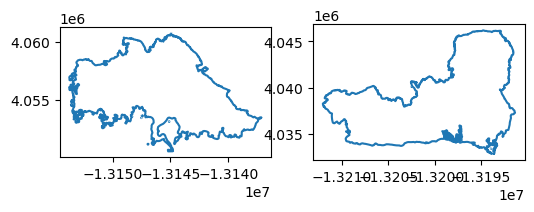

In [3]:
# Plot perimeter data to visualize its contents

# Initialize figure with two axes (so can plot each perimeter on a separate plot)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (6,4))

# Plot Eaton fire perimeter on the left //.boundary allows access to just the border of the polygon
eaton_perimeter.boundary.plot(ax = ax[0])

# And the Palisades fire perimeter on the right
palisades_perimeter.boundary.plot(ax = ax[1])

Looks like both perimeters plot with no issues, and now we have a general idea of what our boundaries look like.

Since we will be combining the fire perimeters into a single plot later on, we want to make sure they have the same CRS.

In [4]:
# What is the CRS?
print(f"The CRS of the Eaton fire perimeter data is {eaton_perimeter.crs}.")
print(f"The CRS of the Eaton fire perimeter data is {palisades_perimeter.crs}.")

The CRS of the Eaton fire perimeter data is EPSG:3857.
The CRS of the Eaton fire perimeter data is EPSG:3857.


In [5]:
# Is it projected or geographic?

# Eaton fire perimeter
print(f"The CRS of Eaton perimeter data is projected? {eaton_perimeter.crs.is_projected}")
print(f"The CRS of Eaton periemeter data is geographic? {eaton_perimeter.crs.is_geographic}")

# Palisades fire perimeter
print(f"The CRS of Palisades perimeter data is projected? {palisades_perimeter.crs.is_projected}")
print(f"The CRS of Palisades periemeter data is geographic? {palisades_perimeter.crs.is_geographic}")

The CRS of Eaton perimeter data is projected? True
The CRS of Eaton periemeter data is geographic? False
The CRS of Palisades perimeter data is projected? True
The CRS of Palisades periemeter data is geographic? False


#### Summary

From our exploration, we have determined the following:
1. Our perimeter data frames plot as one polygon object each, from which we can extract just the boundaries.
2. The CRSs of our data is EPSG:3857.
3. The CRSs is projected, not geographic.

### Landsat (NetCDF) Data Import and Exploration

Similarly to our fire perimeter data, we want to read in our remote sensing data and take a look at its features, such as dimensions, variables, and attributes.

In [6]:
# Read in data, using os to build file path
fp = os.path.join('data', 'landsat8-2025-02-23-palisades-eaton.nc')

# a. Import landsat data using `xr.open_dataset()` from the xarray library
landsat = xr.open_dataset(fp, engine="netcdf4")

In [7]:
# View of landsat xarray
landsat

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...

In [8]:
# What/how are the coordinates stored?
landsat.coords

Coordinates:
  * y        (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x        (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time     datetime64[ns] 8B ...

In [9]:
# Dimensions
landsat.dims

FrozenMappingWarningOnValuesAccess({'y': 1418, 'x': 2742})

In [10]:
# Data types
landsat.dtypes

Frozen({'red': dtype('float32'), 'green': dtype('float32'), 'blue': dtype('float32'), 'nir08': dtype('float32'), 'swir22': dtype('float32'), 'spatial_ref': dtype('int64')})

#### e. Summary 

From our preliminary exploration, we have determined the following:
1. `landsat` contains three kinds of coordinates: x, y (both stored as floats, in metre units), and time (stored as a datetime object, specifically '2025-02-23').
2. The data variables are `red`, `green`, `blue`, `nir08`, and `swir22`, all stored as floats. These are the different bands of light that this data set stores information on. There is also another variable called `spatial_ref`, most likely storing geographic information (and is stored as an integer).
3. The dimensions are x (2742 values long) and y (1418 values long).

### Restoring geospatial information of `landsat`

In [11]:
# a. CRS of landsat
print(landsat.rio.crs)

None


According to `.rio.crs`, this data set does not have a CRS. It appears that it our `xarray.DataSet` may not have automatically loaded as a geospatial object.

There is however a variable called `spatial_ref`, which contians the spatial information we are looking for.

In [12]:
# b. Access CRS through `spatial_ref` variable
# .crs_wkt specifies that our CRS was stored in the well-known text format
landsat_crs = landsat.spatial_ref.crs_wkt
print(landsat_crs)

PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]


In order to transfrom the `landsat` data set into a geospatial object, we can use what is stored in the `spatial_ref` column to assign it a CRS.

In [13]:
# c. Recover and reassign geospatial info through .write_crs
landsat_geo = landsat.rio.write_crs(landsat_crs)

In [14]:
# d. Print new CRS info
print(landsat_geo.rio.crs)

EPSG:32611


### Create true color image

True Color imagery displays the Earth in colors similar to what we might see with our own eyes, like a "photograph" of the earth and ocean from the satellite perspective. It utilizes the three channels that are sensitive to the red, green, and blue visible light, or RGB.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


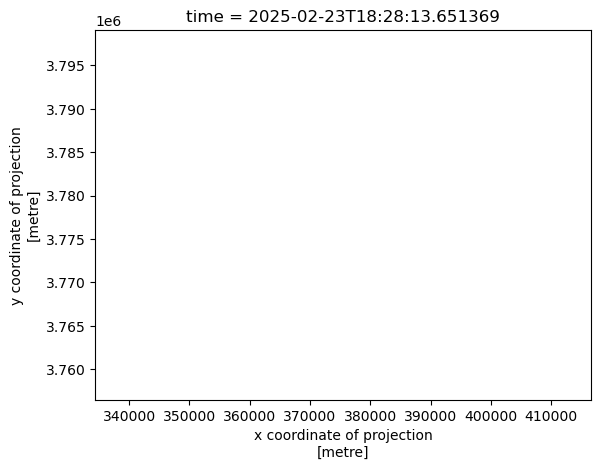

In [15]:
# a. Plot red, green, and blue variables, following RGB to make it a true color image
# .imshow() tells our data to display as an image, which is a necessary function for visualizing raster data
landsat[['red', 'green', 'blue']].to_array().plot.imshow()

Our plotting is unsucessful, and there are two warning messages to be addressed.

/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


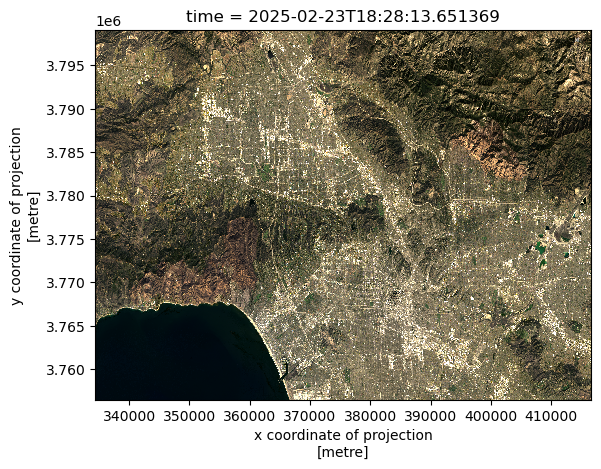

In [16]:
# b. `robust = True` argument tells .plot() to use the 2nd and 98th percentiles as min and max values
# This helps avoid the use of outliers which "smoosh" the rest of the data

landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)

In [17]:
# c. Identify NA values
landsat[["red", "green", "blue"]].isnull().any()


<xarray.Dataset> Size: 11B
Dimensions:  ()
Coordinates:
    time     datetime64[ns] 8B 2025-02-23T18:28:13.651369
Data variables:
    red      bool 1B False
    green    bool 1B True
    blue     bool 1B True

From the output above, we can see that when we checked for *any* NA values in our the red, green, and blue bands of the landsat data, variables `green` and `blue` returned `True`, meaning they contain NA values.

In [18]:
# To check how many NA values exist in each variable, we can sum by band
print(landsat["green"].isnull().sum())
print(landsat["blue"].isnull().sum())

<xarray.DataArray 'green' ()> Size: 8B
array(1)
Coordinates:
    time     datetime64[ns] 8B 2025-02-23T18:28:13.651369
<xarray.DataArray 'blue' ()> Size: 8B
array(109)
Coordinates:
    time     datetime64[ns] 8B 2025-02-23T18:28:13.651369


According to the output above, the green band has 1 NA value and the blue band has 109 NA values. To fix this issue and remove the warning when we plot, we can fill the NA values with 0.

In [19]:
# d. Substitute NA values in landsat for 0
landsat = landsat.fillna(0)

# Confirm there are no more NA values
landsat[['red', 'green', 'blue']].isnull().any()

<xarray.Dataset> Size: 11B
Dimensions:  ()
Coordinates:
    time     datetime64[ns] 8B 2025-02-23T18:28:13.651369
Data variables:
    red      bool 1B False
    green    bool 1B False
    blue     bool 1B False

Because `is.null().any()` returns False for all variables, we now know there are 0 NA values in `landsat[['red', 'green', 'blue']]`

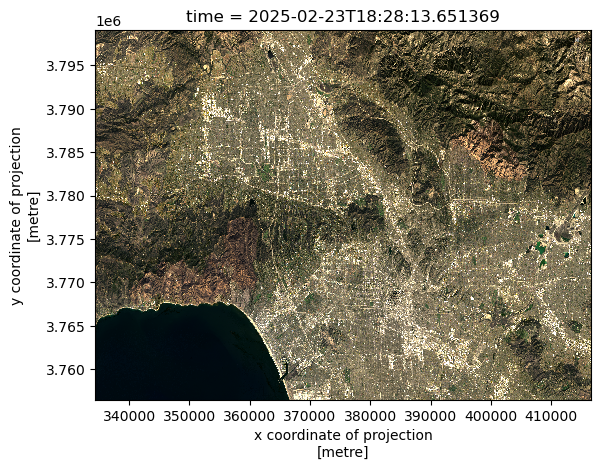

In [20]:
# e. Plot true color image (this time, without the warnings)
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)

*f. Comparison of ouputs for parts (a) and (e).*

The output in part (a) had the x coordinates and y coordinates of the projection as its x- and y-axes, yet the plot itself was blank. This is because there were extreme outliers somewhere in our band values; as our plot tried to account for those, the range of the values we were actually interested in (most of them) were squished, and we weren't able to see any differentation in color. Hence, it was blank. These outliers most likely came from clouds in the images, which often correspond to outlier RGB values.

By adding `robust = True` to our `.imshow()` function, we were able to coerce our plot to use the 2nd and 98th percentile of our data as the minimum and maximum values `.plot()` uses when determining the scale of colors. This omits the issue of outliers, allowing us to see color in the plot in part (e).

The other error that came up in part (a) was that there was an invalid value located somewhere in our data. Although this was not visible to the naked eye (at least not to me), by filling those NA values with 0s, we were able to get a happy final plot!

### False color image

False color images use colors not found in visible light, such as infrared, which are assigned to different bands of the visible light spectrum (RGB). This helps us visualize phenomenom that can be observed with reflectance patterns, but not by the human eye.

Here, we create a false color image by plotting the short-wave infrared (swir22), near-infrared, and red variables (in that order). We do this because those three wavelengths are useful in determining vegetation health.

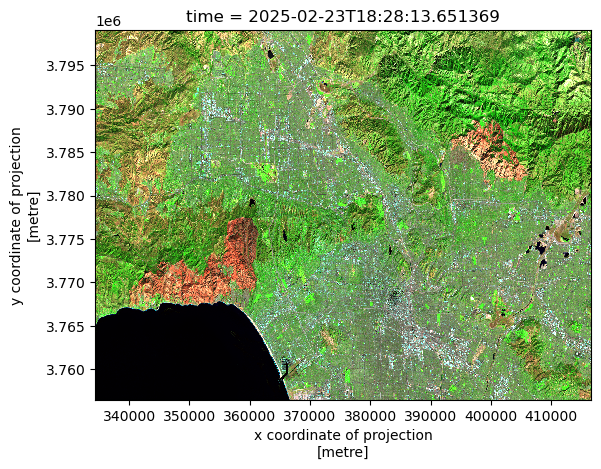

In [21]:
# Plot short-wave infrared, near-infrared, and red variables, following RGB to make a false color image
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

### Final Map (false color image and fire perimeters)

Using our false color image and the Eaton and Palisades fire boundaries, we can explore the relationship between vegetation health and where the fires occured.

In [22]:
# Ensuring that CRSs of fire perimeter data match that of landsat
# Changing fire perimeter data to the landsat CRS ; sourced from original exploration, where landsat_crs = 'epsg:32611'
eaton_perimeter = eaton_perimeter.to_crs(landsat_crs)
palisades_perimeter = palisades_perimeter.to_crs(landsat_crs)

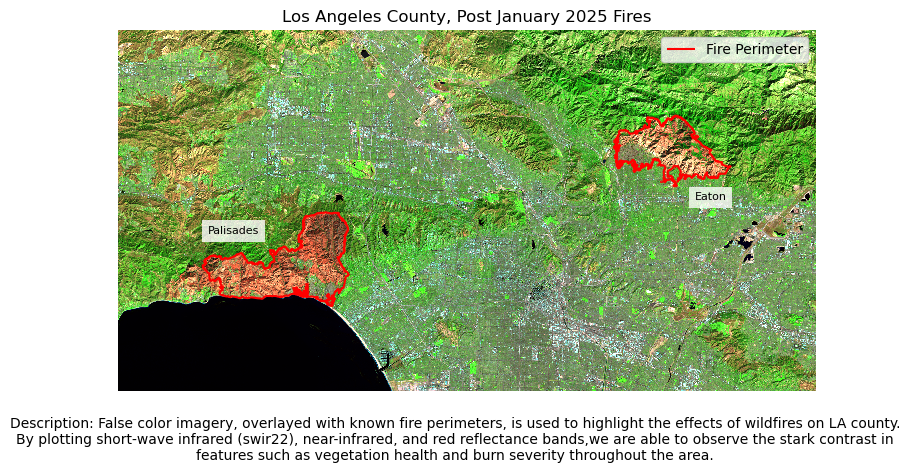

In [ ]:
# Initialize figure with one axes
fig, ax = plt.subplots(figsize = (9,5))

# Plot false color raster image (in the same way as before)
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True,
                                                           ax = ax)

# Plot the Eaton fire perimeter
eaton_perimeter.boundary.plot(ax = ax,
                              color = "red",
                              linewidth = 1.5,
                              label = "Fire Perimeter")             # Set label to create legend for fire perimeter

# Plot the Palisades fire perimeter
palisades_perimeter.boundary.plot(ax = ax,
                                  color = "red",
                                  linewidth = 1.5)

# Add labels to distinguish between Eaton and Palisades boundaries
# .set_bbox() creates background for text (for better visibility)
ax.text(x = 402400, y = 3779000, s = "Eaton", color = "black", fontsize = 8).set_bbox(dict(facecolor='white', alpha = 0.8, edgecolor = 'none'))
ax.text(x = 345000, y = 3775000, s = "Palisades", color = "black", fontsize = 8).set_bbox(dict(facecolor='white', alpha = 0.8, edgecolor = 'none'))

# Turn of x and y axis (are in meters, so don't tell give us a lot of information)
ax.axis('off')

# Plot title and description
plt.title("Los Angeles County, Post January 2025 Fires (False Color Image)")
plt.figtext(x = 0.5, y = 0, s= "Description: False color imagery, overlayed with known fire perimeters, "
                                "is used to highlight the effects of wildfires on LA county." \
                                " By plotting short-wave infrared (swir22), near-infrared, and red reflectance bands," \
                                "we are able to observe the stark contrast in features such as vegetation health and burn severity throughout the area.",
            ha="center", fontsize=10, wrap=True)

# Add legend (for fire perimeters)
plt.legend()

plt.show()

### Conclusion

This notebook included the use of new methods such as `xarray` and `.imshow()` to successfully plot a false color image using raster data.

As proven by our final result, false color imagery is an incredibly useful tool in exploring wildfire impacts (as well as other environmental themes). Through the combination of vector data (perimeter polygons) and rasters, we can more easily observe spatial, temporal, and ecological relationships.

In this analysis, there is a clear difference in color between areas enclosed by the fire perimeters and those on the outside, suggesting the significant negative impact of the fires on vegetation health.